In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir
from PIL import Image
from collections import defaultdict
import csv
import re

from IPython.display import display, clear_output, Image as IPython_Image

# Data loading

In [2]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
DEFAULT_THRESHOLDS = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights). If the get_dataloader() is run, is will 
# overwrite this variable based on the statistics of the test set.
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [3]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [4]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [5]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [6]:
def calculate_label_statistics(label_array, total_n_images):
    label_arr = np.array(label_array).astype(int)
    pos_label_counts_all = np.sum(label_arr, axis=0)
    neg_label_counts_all = total_n_images - pos_label_counts_all
    relative_label_occurrances =  pos_label_counts_all/total_n_images
    pos_weights = neg_label_counts_all / pos_label_counts_all
    
    return pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances

In [7]:
def print_label_statistics(name_of_set, pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances):    
    print(f'\nData set: {name_of_set}')
    print(' Positive label counts\n  ', pos_label_counts_all)
    print(' Negative label counts\n  ', neg_label_counts_all)
    print(' Relative label occurrances\n  ', relative_label_occurrances)
    print(' Pos_weights\n  ', pos_weights)

In [8]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9, use_no_label_imgs = True, transformations=None):
    
    # by default only transform to tensor
    if transformations is None:
        transformations = transforms.Compose([transforms.ToTensor()])
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # apply transformations
                    img_tensor = transformations(img.convert('RGB')).numpy() 

                    # append to dict
                    img_to_data[img_id] = img_tensor

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break
                i += 1

    # If use_no_label_imgs is on, load also all the images that do not have any labels
    i = 0
    for fname in listdir(IMAGE_PATH):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        if img_id not in img_to_data:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)

            # apply transformations
            img_tensor = transformations(img.convert('RGB')).numpy() 

            # append to dict
            img_to_data[img_id] = img_tensor

            if i >= max_images_per_class:
                break
            i += 1

    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    # Write labels to csv file
    #write_labels_to_csv('all', y)
    #write_labels_to_csv('train', y_train)
    #write_labels_to_csv('validation', y_valid)
    #write_labels_to_csv('test', y_test)
    
    # Calculate and print out label statistics to be able to analyze label imbalance
    pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all = calculate_label_statistics(y, len(X))
    pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train = calculate_label_statistics(y_train, len(X_train))
    pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid = calculate_label_statistics(y_valid, len(X_valid))
    pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test = calculate_label_statistics(y_test, len(X_test))
    
    print_label_statistics('all', pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all)
    print_label_statistics('train', pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train)
    print_label_statistics('validation', pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid)
    print_label_statistics('test', pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test)
    
    # Set the pos_weights to be used in the loss function
    label_pos_weights_for_loss = pos_weights_train
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Models

In [9]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [10]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [11]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [12]:
def evaluate(dataloader, model, criterion, device, thresholds=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > thresholds, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [13]:
def train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

In [14]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    for i, batch in enumerate(dataloader):
        n_shown = 0
        
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            img = np.rot90(img, 3)
                                    
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            if n_shown >= n_to_show:
                return

            n_shown += 1

It would be nice to use same naming conventions everywhere. Might be a good idea to rename `y_hat` to `y_pred` or vice versa everywhere (it makes it easier to combine the notebooks). I don't care which way it is. Also the `Xs` and `ys` etc.

The threshold value here is different than elsewhere. Maybe it should be moved to a global or something?

Good idea could be also to check from `visualize_predictions` function how the actual predictions can be easily obtained from `y_pred`.

In [15]:
def predict_X(fr, threshold=0.25):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [16]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 5
bs = 256
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

If you want to test the models that do not seem to work with 128x128 images change the transformation to do the resize.

However, it should be investigated if, for example RESNET, can be made to work with 128x128 images.

In [17]:
#max_images_per_class = 7000
use_no_label_imgs = True
max_images_per_class = 1e9
affix = "_" + str(max_images_per_class) if max_images_per_class < 1e9 else ""

transformations = {
    'train' : transforms.Compose([
            # torchvision.transforms.Resize((224, 224)), # for testing RESNET
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ]),
}
transformations['valid'] = transformations['test'] = transformations['train']

try:
    train_dataloader = torch.load(f'../data/train_dataloader{affix}.dat')
    valid_dataloader = torch.load(f'../data/valid_dataloader{affix}.dat')
    test_dataloader = torch.load(f'../data/test_dataloader{affix}.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(
        bs=bs, 
        transformations=transformations['train'],
        max_images_per_class=max_images_per_class,
        use_no_label_imgs=use_no_label_imgs
    )
    torch.save(train_dataloader, f'../data/train_dataloader{affix}.dat')
    torch.save(valid_dataloader, f'../data/valid_dataloader{affix}.dat')
    torch.save(test_dataloader, f'../data/test_dataloader{affix}.dat')

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

This works with 128x128 and 224x224 images.

I think I achieved the best validation f1 score with 128x128 images and vgg16, around 0.76.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [18]:
if True:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential( 
        nn.Linear(8192, 4096),
        # change input layer to this to work with 224x224 images
        #nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_

I haven't got RESNET models yet working with 128x128 images.

Currently you can add a transform to resize images to 224x224 for testing, achieving validation f1 score of around 0.6. Note that the dataloading was really whopping slow, so I decided to test just with max 200 images from each class. Something to investigate here!

In [19]:
if False:
    model = resnet18(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [20]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

## Train a model or load an existing model from disk

In [27]:
#model_path = '../data/TwoLayerModel_state.dict'
model_path = f'../data/ConvNetModel_state{affix}.dict'

#model = OneLayerModel(224*224*3, 256, n_classes).to(device)
#model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)
#model = ConvNetModel(n_classes=n_classes, keep_prob=.5).to(device)

pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

In [35]:
#model_save_path = '../data/vgg16-small-images-all-data-epoch-11-adam.pth'
#torch.save(model.state_dict(), model_save_path)
#model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [28]:
%time train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=1)

Epoch Train loss   Valid loss   Train F1  Valid F1 
Epoch: 1, iteration: 1, loss: 0.11133764684200287
Epoch: 1, iteration: 2, loss: 0.11944253742694855
Epoch: 1, iteration: 3, loss: 0.11825712025165558
Epoch: 1, iteration: 4, loss: 0.13183706998825073
Epoch: 1, iteration: 5, loss: 0.11629673838615417
Epoch: 1, iteration: 6, loss: 0.12455219030380249
Epoch: 1, iteration: 7, loss: 0.10060308128595352
Epoch: 1, iteration: 8, loss: 0.11667706817388535
Epoch: 1, iteration: 9, loss: 0.10968227684497833
Epoch: 1, iteration: 10, loss: 0.10341773927211761
Epoch: 1, iteration: 11, loss: 0.09721873700618744
Epoch: 1, iteration: 12, loss: 0.09442616254091263
Epoch: 1, iteration: 13, loss: 0.10747431218624115
Epoch: 1, iteration: 14, loss: 0.12612053751945496
Epoch: 1, iteration: 15, loss: 0.09541165083646774
Epoch: 1, iteration: 16, loss: 0.10812090337276459
Epoch: 1, iteration: 17, loss: 0.11860832571983337
Epoch: 1, iteration: 18, loss: 0.1036168709397316
Epoch: 1, iteration: 19, loss: 0.0952894

threshold: 0.05, f1 score: 0.7228536605834961
threshold: 0.1, f1 score: 0.7233600616455078
threshold: 0.15000000000000002, f1 score: 0.724076509475708
threshold: 0.2, f1 score: 0.7257993817329407
threshold: 0.25, f1 score: 0.7258560061454773
threshold: 0.3, f1 score: 0.7269453406333923
threshold: 0.35000000000000003, f1 score: 0.7278744578361511
threshold: 0.4, f1 score: 0.7288583517074585
threshold: 0.45, f1 score: 0.7302254438400269
threshold: 0.5, f1 score: 0.7307531237602234
threshold: 0.55, f1 score: 0.7323186993598938
threshold: 0.6000000000000001, f1 score: 0.7318224906921387
threshold: 0.6500000000000001, f1 score: 0.7334409356117249
threshold: 0.7000000000000001, f1 score: 0.7331785559654236
threshold: 0.7500000000000001, f1 score: 0.7351773381233215
threshold: 0.8, f1 score: 0.7345784902572632
threshold: 0.8500000000000001, f1 score: 0.7348579168319702
threshold: 0.9000000000000001, f1 score: 0.7346250414848328


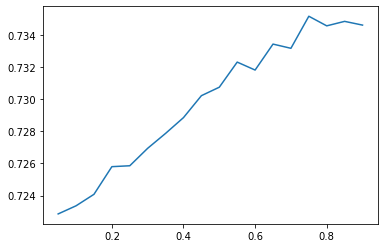

In [30]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if False:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, thresholds=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 0.95, 0.05), f1_scores)

In [ ]:
# PLEASE DO NOT DO THIS.
# When clicking 'Restart & Run all' this will overwrite the just trained model
# PS. Is there a reason for the model.eval() calls here?

# try:
#     model.load_state_dict(torch.load(model_path))
#     model.eval()
#     print("Loaded model")
# except:
#     train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=n_epochs)
#     model.eval()

## Keep training an existing model

NB: This is better to do by just re-running the earlier training -cell. You can change the number of epochs there.

In [ ]:
# # Keep training existing model with a certain number of epochs
# additional_epochs = 5

# if additional_epochs > 0:
#     model.train()
#     train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=additional_epochs)
#     model.eval()

## Save a model to disk

In [ ]:
torch.save(model.state_dict(), model_path)

# Visualization and evaluation

### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


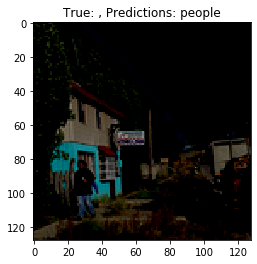

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


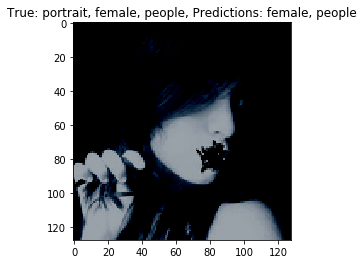

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


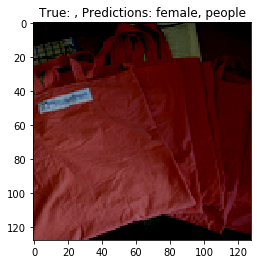

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


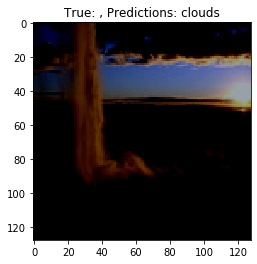

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


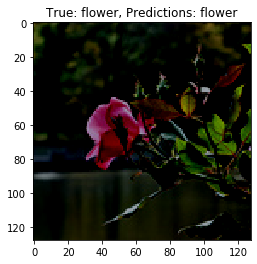

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


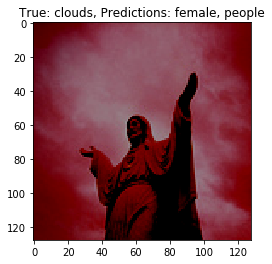

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


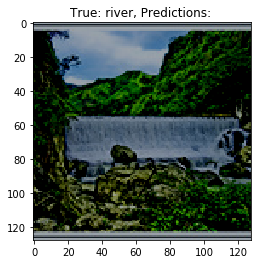

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


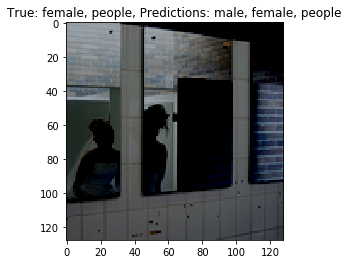

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


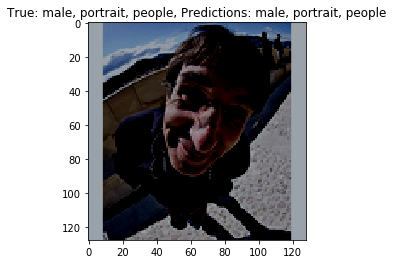

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


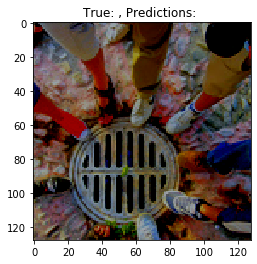

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


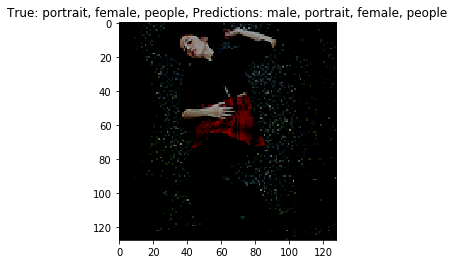

In [38]:
visualize_predictions(model, device, valid_dataloader, n_to_show=10)

### Confusion matrix

In [39]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels{affix}.npy', y_true)
    np.save(f'../data/valid_pred_labels{affix}.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report{affix}.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix{affix}.png')

/home/akir/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [40]:
# Show classification report
with open(f'../data/valid_classification_report{affix}.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.09      0.39      0.15        23
           1       0.53      0.89      0.67       213
           2       0.20      0.33      0.25         9
           3       0.30      0.80      0.44        74
           4       0.54      0.84      0.65        91
           5       0.16      0.68      0.26        77
           6       0.37      0.91      0.53       158
           7       0.50      0.80      0.62       614
           8       0.65      0.89      0.75       635
           9       0.34      0.63      0.44       113
          10       0.25      0.85      0.39       130
          11       0.50      0.89      0.64       647
          12       0.63      0.94      0.75      1303
          13       0.29      0.71      0.41        38

   micro avg       0.50      0.87      0.63      4125
   macro avg       0.38      0.75      0.50      4125
weighted avg       0.53      0.87      0.66      4125
 samples avg       0.39   

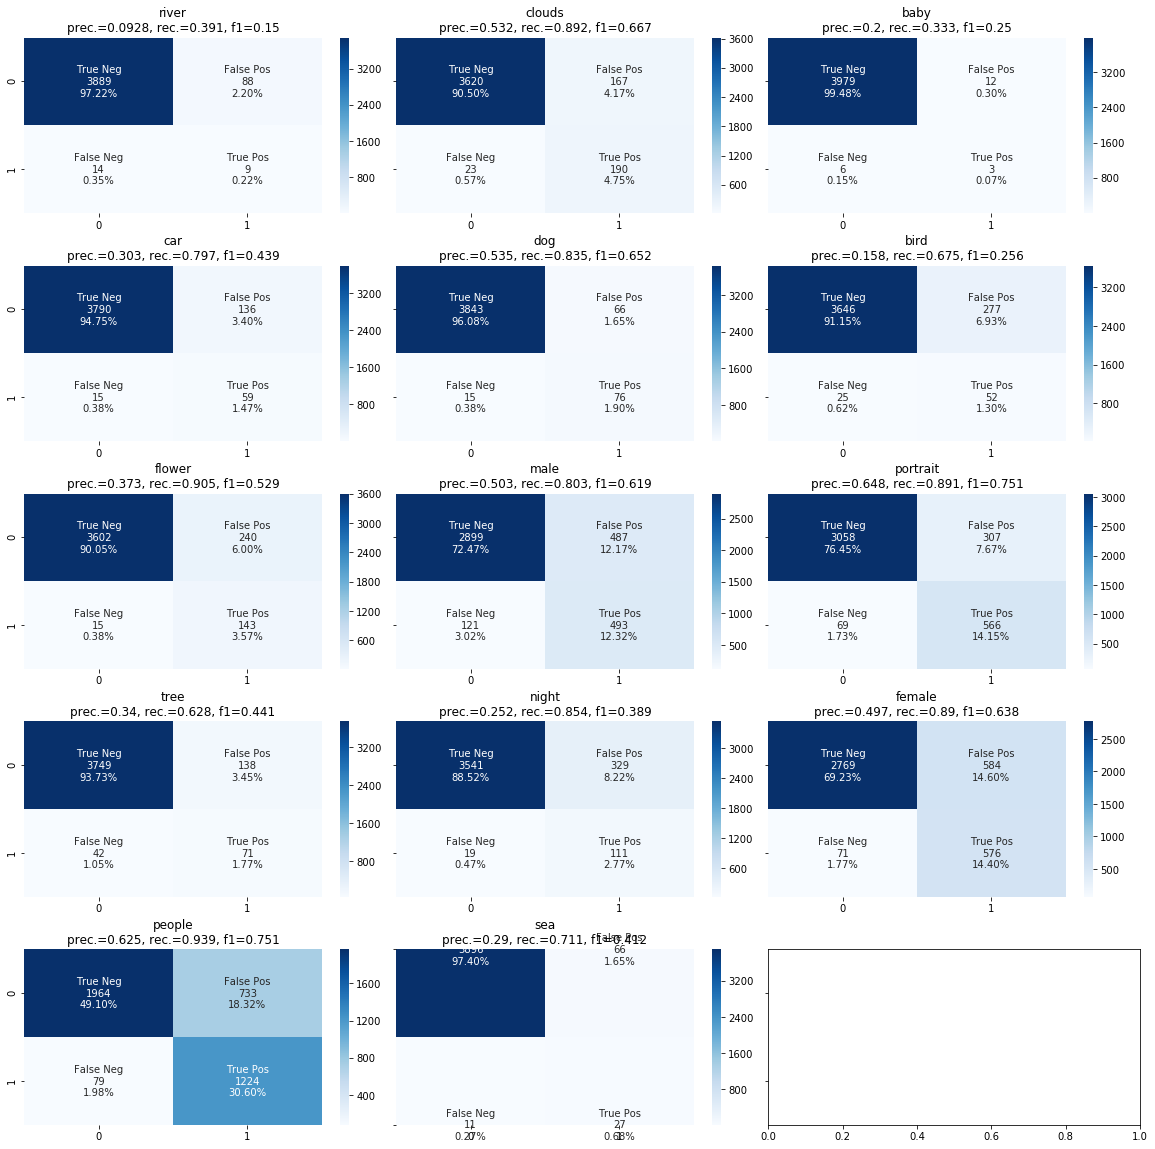

In [41]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix{affix}.png', width=1000)